## HW2. Feature selection

### Importing

In [1]:
from sklearn.datasets import load_boston
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Download dataset

In [2]:
data = load_boston()
X = data['data']
y = data['target']
columns = data.feature_names

print(X.shape, type(X))
print(y.shape, type(y))

(506, 13) <class 'numpy.ndarray'>
(506,) <class 'numpy.ndarray'>


In [3]:
print(columns)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


### Task 1. Filter method for feature selection

In [4]:
def pearson_corr(v):
    return np.dot(v - v.mean(), y - y.mean())/(np.linalg.norm(v - v.mean())*np.linalg.norm(y - y.mean()))


In [5]:
def plot_importances(imp_arr, columns=None, title='Importances'):
    
    n_bars = len(imp_arr)
        
    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.barh(range(n_bars), imp_arr[:, 1], color='r', align="center")
    plt.ylim(-1, n_bars)
    if columns is not None:
        plt.yticks(range(n_bars), [columns[int(i)] for i in imp_arr[:, 0]])
    else:
        plt.yticks(range(n_bars), [f'Feature {int(i)}' for i in imp_arr[:, 0]])
    plt.show()

In [6]:
importances = np.apply_along_axis(pearson_corr, 0, X)
importances = np.array(sorted(enumerate(importances), key = lambda x: np.fabs(x[1]), reverse=True))
print(importances)

top_5_filter = columns[[int(i) for i in importances[:5, 0]]]

[[12.         -0.73766273]
 [ 5.          0.69535995]
 [10.         -0.50778669]
 [ 2.         -0.48372516]
 [ 9.         -0.46853593]
 [ 4.         -0.42732077]
 [ 0.         -0.38830461]
 [ 8.         -0.38162623]
 [ 6.         -0.37695457]
 [ 1.          0.36044534]
 [11.          0.33346082]
 [ 7.          0.24992873]
 [ 3.          0.17526018]]


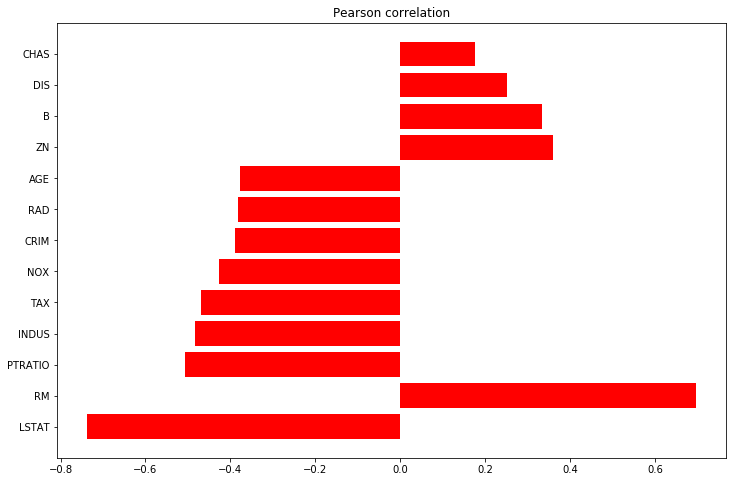

In [7]:
plot_importances(importances, columns, title='Pearson correlation')

In [8]:
print(f'The most important features by pearson correlation:\n{top_5_filter}')

The most important features by pearson correlation:
['LSTAT' 'RM' 'PTRATIO' 'INDUS' 'TAX']


### Scale data

In [9]:
from sklearn import preprocessing

In [10]:
X_scaled = preprocessing.scale(X)

### Task 2.1. Forward feature selection

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [12]:
def train_model(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

In [13]:
def evaluate_model_mse(model, X_test, y_true):
    y_pred = model.predict(X_test)
    return mean_squared_error(y_true, y_pred)

In [14]:
def forward_selection(X, y, stop_amount=None):
    feature_amount = X.shape[1]
    all_features = set(range(feature_amount))
    stop_amount = stop_amount or feature_amount

    best_features = []
    best_mse = []
    while len(best_features) < stop_amount:
        remaining_features = list(all_features - set(best_features))
        feat_to_mse = {}
        for feature in remaining_features:
            curr_features = best_features + [feature]
            X_step = X[:, curr_features]

            X_train, X_test, y_train, y_test = train_test_split(X_step, y, test_size=0.3, random_state=42)

            model = train_model(X_train, y_train)
            mse_step = evaluate_model_mse(model, X_test, y_test)
            feat_to_mse[feature] = mse_step

        best_feature = min(feat_to_mse, key=feat_to_mse.get)
        best_features.append(best_feature)
        best_mse.append(feat_to_mse[best_feature])
    
    return best_features, best_mse

In [15]:
forward_features, forward_mse = forward_selection(X_scaled, y, 5)
print(forward_features)

forward_features = columns[forward_features]
print(f'Forward selection 5 best features: {forward_features}, MSE={forward_mse[-1]:.4f}')

[12, 5, 10, 7, 4]
Forward selection 5 best features: ['LSTAT' 'RM' 'PTRATIO' 'DIS' 'NOX'], MSE=22.7068


### Task 2.2. Backward feature selection

In [16]:
def backward_selection(X, y, stop_amount=None):
    feature_amount = X.shape[1]
    all_features = set(range(feature_amount))
    stop_amount = stop_amount or feature_amount

    best_features = list(all_features)
    best_mse = []
    while len(best_features) > stop_amount:
        feat_to_mse = {}
        for feature in best_features:
            curr_features = list(best_features)
            curr_features.remove(feature)
            X_step = X[:, curr_features]

            X_train, X_test, y_train, y_test = train_test_split(X_step, y, test_size=0.3, random_state=42)

            model = train_model(X_train, y_train)
            mse_step = evaluate_model_mse(model, X_test, y_test)
            feat_to_mse[feature] = mse_step

        worst_feature = min(feat_to_mse, key=feat_to_mse.get)
        best_features.remove(worst_feature)
        best_mse.append(feat_to_mse[worst_feature])

    return best_features, best_mse

In [17]:
backward_features, backward_mse = backward_selection(X_scaled, y, 5)
print(backward_features)

backward_features = columns[backward_features]
print(f'Backward selection 5 best features: {backward_features}, MSE={backward_mse[-1]:.4f}')

[4, 5, 7, 10, 12]
Backward selection 5 best features: ['NOX' 'RM' 'DIS' 'PTRATIO' 'LSTAT'], MSE=22.7068


### Task 3. L1 - regularization 

In [18]:
from sklearn.linear_model import Lasso, LassoCV

In [19]:
def plot_coeffs(coeffs):
    plt.figure(figsize=(12, 8))
    
    ax = plt.gca()
    ax.plot(alphas*2, coeffs)
    ax.set_xscale('log')
    
    plt.axis('tight')
    plt.xlabel('alpha')
    plt.ylabel('weights')
    plt.show()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
alphas = 10**np.linspace(2, -2, 100)*0.5
precision = 5 * 10 **(-6)

In [21]:
lasso = Lasso(max_iter=10000, normalize=True)
coeffs = []
flag = True

for a in alphas[::-1]:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coeffs.append(lasso.coef_)
    
    if flag and sum(np.fabs(lasso.coef_) > precision) == 5:
        alpha = a
        flag = False
    
print(alpha)    

0.05616620164890133


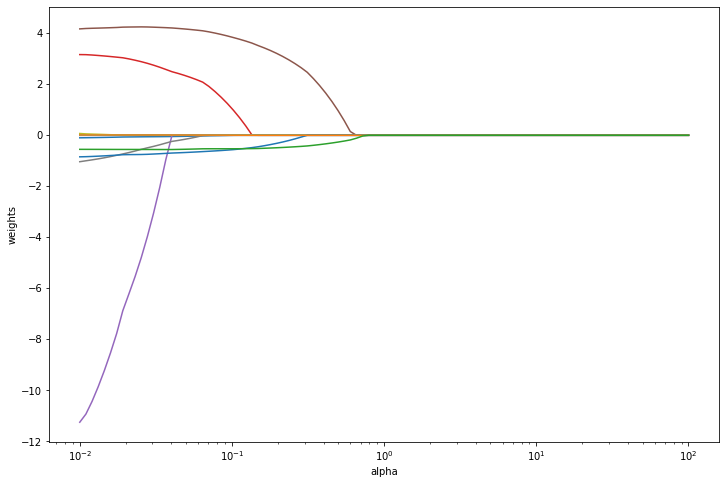

In [22]:
plot_coeffs(coeffs[::-1])

In [23]:
lasso.set_params(alpha=alpha)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

mse_lasso = mean_squared_error(y_test, y_pred)

print(f'The best penalty is {alpha:.4f}')
print(f'The MSE is {mse_lasso:.4f}')

coeffs = pd.DataFrame(list(zip(columns, lasso.coef_)), columns=['feature', 'coefficient'])

The best penalty is 0.0562
The MSE is 26.7230


In [24]:
lasso_coeffs = coeffs.reindex(coeffs.coefficient.abs().sort_values().index)
lasso_coeffs

,feature,coefficient
0,CRIM,-0.000000
1,ZN,0.000000
2,INDUS,-0.000000
4,NOX,-0.000000
6,AGE,-0.000000
7,DIS,-0.000000
8,RAD,-0.000000
9,TAX,-0.000000
11,B,0.002600
12,LSTAT,-0.527264


In [25]:
top_5_lasso = columns[lasso_coeffs.tail().index]

In [26]:
print(f'Lasso 5 best features: {top_5_lasso}, MSE={mse_lasso:.4f}')

Lasso 5 best features: ['B' 'LSTAT' 'PTRATIO' 'CHAS' 'RM'], MSE=26.7230


In [27]:
lassocv = LassoCV(alphas=alphas, cv=10, max_iter=10000, random_state = 42)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

mse_lassocv = mean_squared_error(y_test, y_pred)

print(f'The best penalty is {lassocv.alpha_:.4f}')
print(f'The MSE is {mse_lassocv:.4f}')

coeffs = pd.DataFrame(list(zip(columns, lasso.coef_)), columns=['feature', 'coefficient'])

The best penalty is 0.0050
The MSE is 22.6739


In [28]:
lassocv_coeffs = coeffs.reindex(coeffs.coefficient.abs().sort_values().index)
lassocv_coeffs

,feature,coefficient
2,INDUS,-0.000000
9,TAX,-0.000774
6,AGE,-0.004892
11,B,0.010599
1,ZN,0.018027
8,RAD,0.070071
0,CRIM,-0.098962
12,LSTAT,-0.550956
10,PTRATIO,-0.844279
7,DIS,-1.036162


In [29]:
top_5_lassocv = columns[lassocv_coeffs.tail().index]

In [30]:
print(f'LassoCV 5 best features: {top_5_lassocv}, MSE={mse_lassocv:.4f}')

LassoCV 5 best features: ['PTRATIO' 'DIS' 'CHAS' 'RM' 'NOX'], MSE=22.6739


### Find MSE for filter columns

In [31]:
model = train_model(X_train, y_train)
mse_filter = evaluate_model_mse(model, X_test, y_test)

### Resume

In [32]:
data = {
    'Top_Features': [top_5_filter, forward_features, backward_features, top_5_lasso, top_5_lassocv],
    'Amount of Features': [5, 5, 5, 5, 12],
    'MSE': [mse_filter, forward_mse[-1], backward_mse[-1], mse_lasso, mse_lassocv]
}
pd.DataFrame.from_dict(data, orient='index', columns=['Filter', 'Forward', 'Backward', 'Lasso', 'LassoCV'])

,Filter,Forward,Backward,Lasso,LassoCV
Top_Features,"[LSTAT, RM, PTRATIO, INDUS, TAX]","[LSTAT, RM, PTRATIO, DIS, NOX]","[NOX, RM, DIS, PTRATIO, LSTAT]","[B, LSTAT, PTRATIO, CHAS, RM]","[PTRATIO, DIS, CHAS, RM, NOX]"
Amount of Features,5,5,5,5,12
MSE,21.5174,22.7068,22.7068,26.723,22.6739
